In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',300)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

from fastai.tabular import *

In [2]:
target = pd.read_csv('target2',header=None,index_col=0)

In [3]:
target = pd.read_csv('target2',header=None,index_col=0)
train = feather.read_dataframe('best_from_recent_groupped_train')
test = feather.read_dataframe('best_from_recent_groupped_test')


new_test_cols = feather.read_dataframe('new_test_columns_with_promos_fixed')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


new_test_cols =  feather.read_dataframe('gropped_columns_per_month_to_last_ver2')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


train_out = feather.read_dataframe('train_months_outliner_percent')
test_out = feather.read_dataframe('test_months_outliner_percent')

train = pd.merge(train,train_out,on='card_id',how='left')
test = pd.merge(test,test_out,on='card_id',how='left')

In [4]:
import pickle
with open('list_of_best_folds.pickle', 'rb') as f:
    best_cols_for_folds = pickle.load(f)

In [5]:
train['agged_all_city_id_modeplus'] = train.agged_all_city_id_modeplus.apply(lambda x: 1 if x <= 6 else x-5)

In [6]:
train['target'] = target
train = train[best_cols_for_folds[1][1] + ['target']]

In [7]:
random_idx = [random.randint(0,train.shape[0]) for x in range(25000)]
procs = [FillMissing,Categorify,Normalize]

In [8]:
for col in [y for y,x in zip(train.dtypes.index,train.dtypes) if x==np.float32]:
    train[col] = train[col].astype(np.float64)
    test[col] = test[col].astype(np.float64)

In [9]:
data = TabularDataBunch.from_df(path='.',df=train,dep_var='target',valid_idx=random_idx,procs=procs,cat_names=best_cols_for_folds[1][3])

In [10]:
learn = tabular_learner(data, layers=[200,100,50], metrics=root_mean_squared_error,emb_szs={'agged_all_city_id_modeplus':10})

In [73]:
learn.lr_find(start_lr=1e-14,end_lr=1,wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


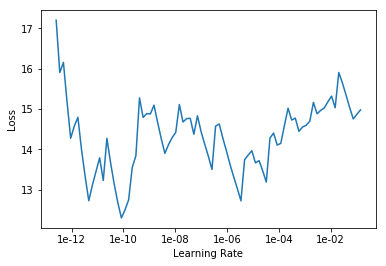

In [76]:
learn.recorder.plot()

In [75]:
#learn.fit(epochs=1,lr=5e-1,wd=0.1)

In [77]:
learn.fit(epochs=1,lr=1e-10,wd=0.1)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,14.370234,20.152901,3.525425,00:42


In [31]:
learn.save('elo-test')

In [72]:
learn = learn.load('elo-test')